## Color thresholding (manual)

### 1. Imports

In [17]:
import time

import cv2
import numpy as np
from matplotlib import pyplot as plt

from helpers.limbus_detection import detect_circle, detect_pupil_thresh
from helpers.view_detection import get_view_mask


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


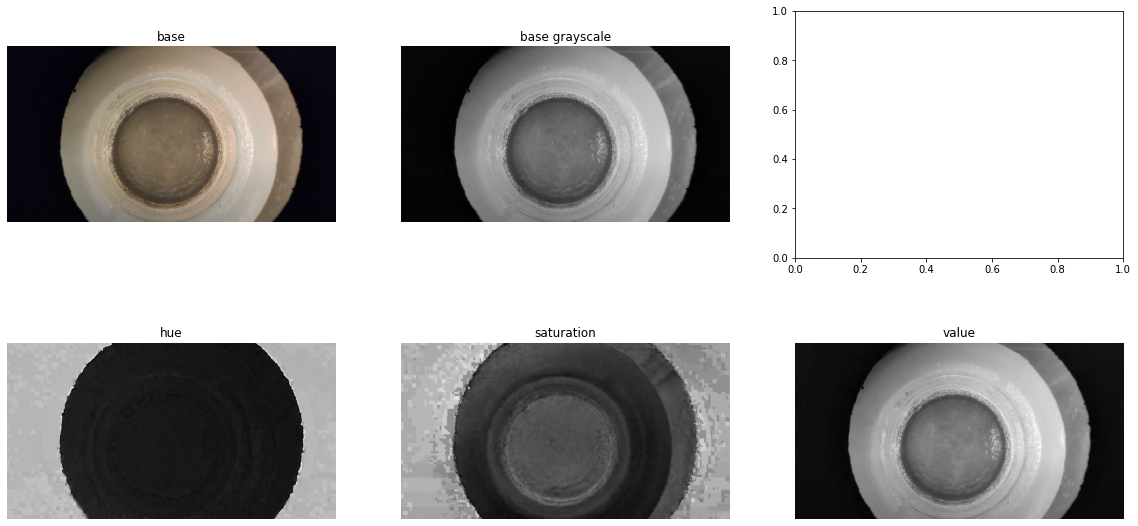

size: 1441x773


In [18]:
# scale = 0.33
scale = 1.0

base = cv2.imread('data/artificial/bioniko_rhexis_base8.png', cv2.IMREAD_COLOR)
base = cv2.resize(base, (0, 0), fx=scale, fy=scale)

base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)

base_hue = base_hsv[:, :, 0]
base_saturation = base_hsv[:, :, 1]
base_value = base_hsv[:, :, 2]

fig, ((plot1, plot2, _), (plot3, plot4, plot5)
      ) = plt.subplots(2, 3, figsize=(20, 10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base grayscale')
plot2.imshow(base_gray, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('hue')
plot3.imshow(base_hue, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('saturation')
plot4.imshow(base_saturation, cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('value')
plot5.imshow(base_value, cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

print('size: %dx%d' % (base.shape[1], base.shape[0]))

### 2. Relevant anatomy selection with mouse clicking
Select as many points as needed. Press any key to quit.

selected points: [(653, 320), (810, 399), (781, 543), (610, 531), (674, 444)]


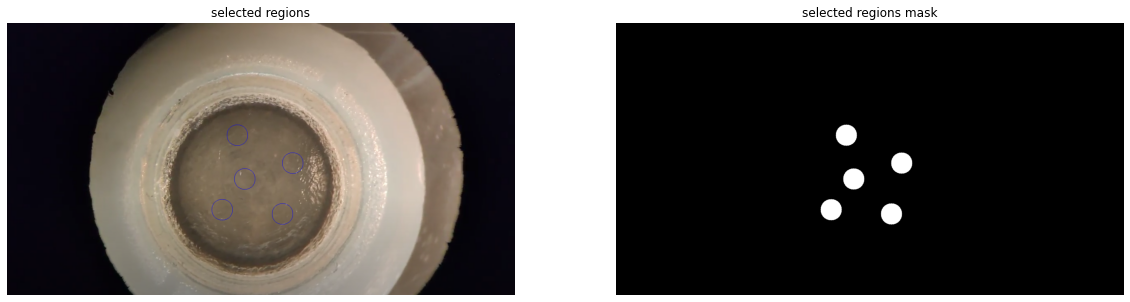

In [19]:
SELECTION_RADIUS = 30

points = []


def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONUP:
        points.append((x, y))


window_name = 'point selection'
cv2.namedWindow(window_name)
cv2.setMouseCallback(window_name, mouse_callback)
cv2.imshow(window_name, base)

ip = cv2.waitKey(0) & 0xFF
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)

print('selected points: %s' % str(points))

# visualization
base_rgb_copy = base_rgb.copy()
selection_mask = np.zeros(base_rgb.shape[:2], dtype=np.uint8)
for point in points:
    cv2.circle(base_rgb_copy, point, SELECTION_RADIUS, (0, 0, 255))
    cv2.circle(selection_mask, point, SELECTION_RADIUS, 255, cv2.FILLED)

fig, plots = plt.subplots(1, 2, figsize=(20, 8))
plots[0].set_title('selected regions')
plots[0].imshow(base_rgb_copy)
plots[0].axis('off')

plots[1].set_title('selected regions mask')
plots[1].imshow(selection_mask, cmap='gray')
plots[1].axis('off')

plt.show()

### 3. Histogram computation

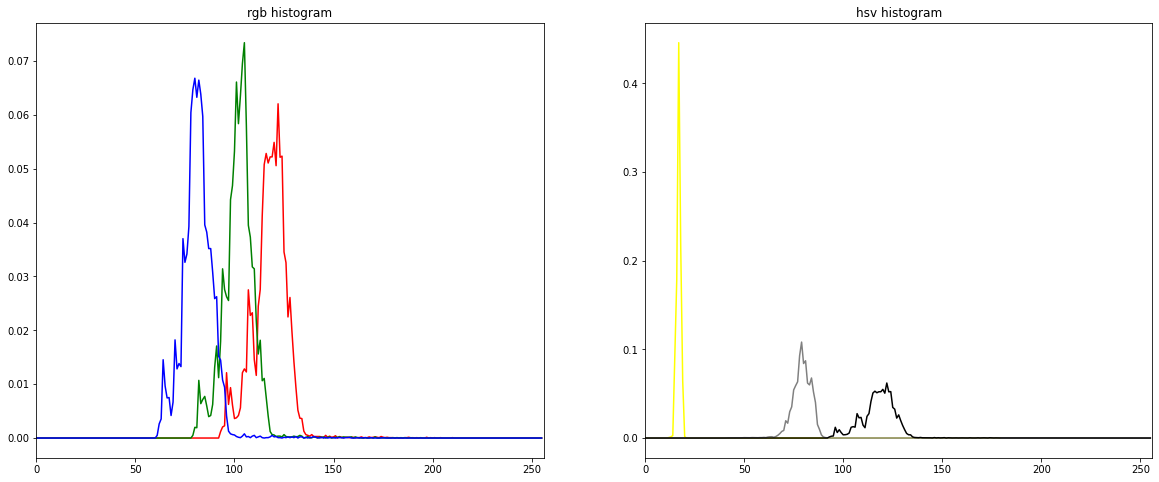

In [20]:
hist_r = cv2.calcHist([base_rgb], [0], selection_mask, [256], [0, 256])
hist_r /= hist_r.sum()
hist_g = cv2.calcHist([base_rgb], [1], selection_mask, [256], [0, 256])
hist_g /= hist_g.sum()
hist_b = cv2.calcHist([base_rgb], [2], selection_mask, [256], [0, 256])
hist_b /= hist_b.sum()

hist_h = cv2.calcHist([base_hsv], [0], selection_mask, [180], [0, 180])
hist_h /= hist_h.sum()
hist_s = cv2.calcHist([base_hsv], [1], selection_mask, [256], [0, 256])
hist_s /= hist_s.sum()
hist_v = cv2.calcHist([base_hsv], [2], selection_mask, [256], [0, 256])
hist_v /= hist_v.sum()

fig, plots = plt.subplots(1, 2, figsize=(20, 8))
plots[0].set_title('rgb histogram')
plots[0].plot(hist_r, color='red')
plots[0].plot(hist_g, color='green')
plots[0].plot(hist_b, color='blue')
plots[0].set_xlim([0, 256])

plots[1].set_title('hsv histogram')
plots[1].plot(hist_h, color='yellow')
plots[1].plot(hist_s, color='grey')
plots[1].plot(hist_v, color='black')
plots[1].set_xlim([0, 256])

plt.show()

### 4. Histogram back projection

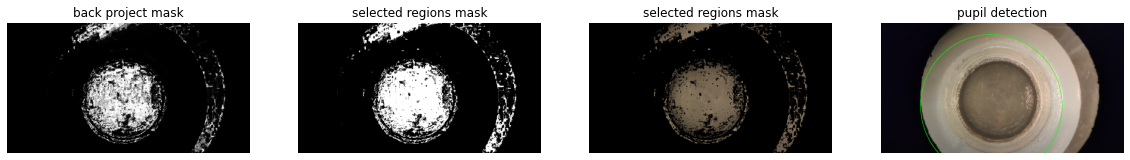

In [21]:
hist_hs = cv2.calcHist([base_hsv], [0, 1], selection_mask, [
                       180, 256], [0, 180, 0, 256])
back_project = cv2.calcBackProject(
    [base_hsv], [0, 1], hist_hs, [0, 180, 0, 256], 1)

_, back_project_mask = cv2.threshold(back_project, 20, 255, cv2.THRESH_BINARY)
base_rgb_copy = base_rgb.copy()
base_rgb_copy[back_project_mask == 0] = [0, 0, 0]

base_rgb_copy2 = base_rgb.copy()
circle = detect_pupil_thresh(back_project_mask, pca_correction=True)
cv2.circle(base_rgb_copy2, tuple(circle[:2].round().astype(
    np.int64)), round(circle[2]), (0, 255, 0), 2)

fig, plots = plt.subplots(1, 4, figsize=(20, 8))
plots[0].set_title('back project mask')
plots[0].imshow(back_project, cmap='gray')
plots[0].axis('off')

plots[1].set_title('selected regions mask')
plots[1].imshow(back_project_mask, cmap='gray')
plots[1].axis('off')

plots[2].set_title('selected regions mask')
plots[2].imshow(base_rgb_copy)
plots[2].axis('off')

plots[3].set_title('pupil detection')
plots[3].imshow(base_rgb_copy2)
plots[3].axis('off')

plt.show()

### 5. Connected components used to remove unwanted structures

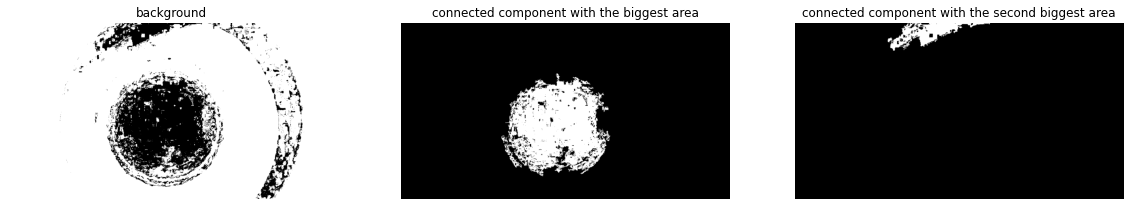

In [22]:
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(
    back_project_mask)
biggest_area_labels = np.flip(np.argsort(stats[:, 4]))

labels_background = labels.copy()
labels_background[labels != 0] = 0
labels_background[labels == 0] = 255

labels_prominent1 = labels.copy()
labels_prominent1[labels != biggest_area_labels[1]] = 0
labels_prominent1[labels == biggest_area_labels[1]] = 255

labels_prominent2 = labels.copy()
labels_prominent2[labels != biggest_area_labels[2]] = 0
labels_prominent2[labels == biggest_area_labels[2]] = 255

fig, plots = plt.subplots(1, 3, figsize=(20, 8))
plots[0].set_title('background')
plots[0].imshow(labels_background, cmap='gray')
plots[0].axis('off')

plots[1].set_title('connected component with the biggest area')
plots[1].imshow(labels_prominent1, cmap='gray')
plots[1].axis('off')

plots[2].set_title('connected component with the second biggest area')
plots[2].imshow(labels_prominent2, cmap='gray')
plots[2].axis('off')

plt.show()


### 6. Hough circle detection applied on the back projection

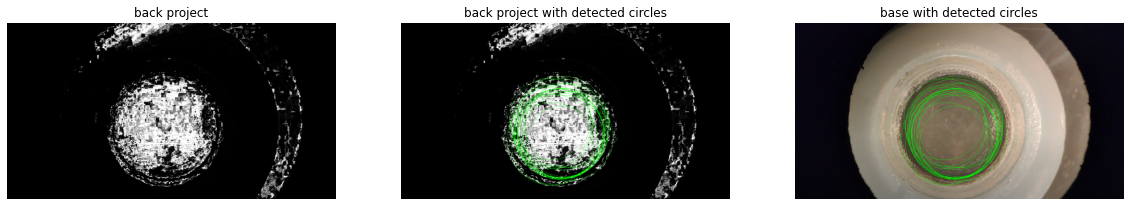

In [23]:
circles = detect_circle(back_project, return_all=True)

base_rgb_copy = base_rgb.copy()
back_project_copy = cv2.cvtColor(back_project, cv2.COLOR_GRAY2RGB)
for circle in circles[:20]:
    cv2.circle(base_rgb_copy, (round(circle[0]), round(
        circle[1])), round(circle[2]), (0, 255, 0))
    cv2.circle(back_project_copy, (round(circle[0]), round(
        circle[1])), round(circle[2]), (0, 255, 0))

# visualization
fig, plots = plt.subplots(1, 3, figsize=(20, 8))
plots[0].set_title('back project')
plots[0].imshow(back_project, cmap='gray')
plots[0].axis('off')

plots[1].set_title('back project with detected circles')
plots[1].imshow(back_project_copy)
plots[1].axis('off')

plots[2].set_title('base with detected circles')
plots[2].imshow(base_rgb_copy)
plots[2].axis('off')

plt.show()

### 7. Correlation based approach
Manual creation of sliding kernel is a major hindrance.

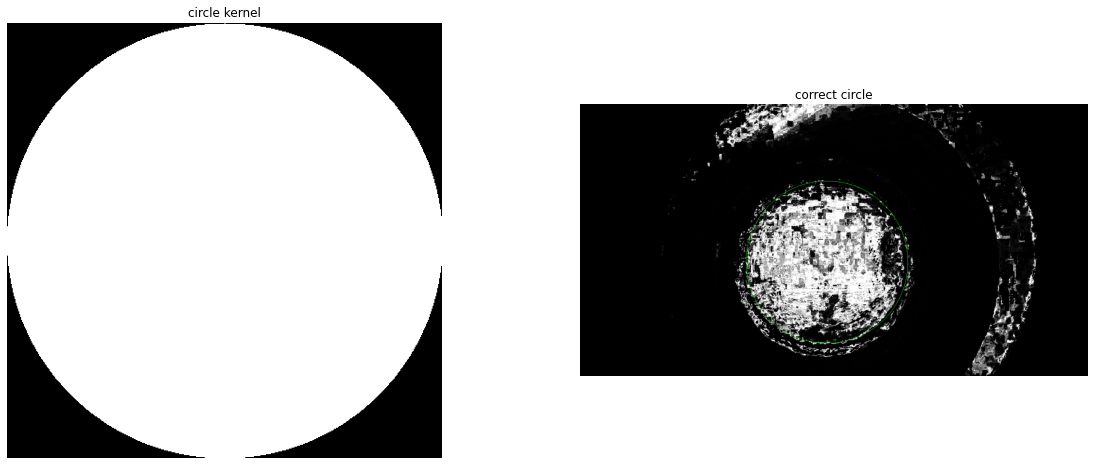

In [24]:
# data/artificial/bioniko_rhexis_base6.png
# CORRECT_CIRCLE_RADIUS = 150
# CORRECT_CIRCLE_CENTER = (410,1000)

# data/artificial/bioniko_rhexis_base8.png
CORRECT_CIRCLE_RADIUS = 230
CORRECT_CIRCLE_CENTER = (700, 450)

circle_kernel = cv2.getStructuringElement(
    cv2.MORPH_ELLIPSE, (2*CORRECT_CIRCLE_RADIUS, 2*CORRECT_CIRCLE_RADIUS))
circle_kernel *= 255

back_project_copy = cv2.cvtColor(back_project, cv2.COLOR_GRAY2RGB)
cv2.circle(back_project_copy, CORRECT_CIRCLE_CENTER,
           CORRECT_CIRCLE_RADIUS, (0, 255, 0))

# visualization
fig, plots = plt.subplots(1, 2, figsize=(20, 8))
plots[0].set_title('circle kernel')
plots[0].imshow(circle_kernel, cmap='gray')
plots[0].axis('off')

plots[1].set_title('correct circle')
plots[1].imshow(back_project_copy)
plots[1].axis('off')

plt.show()

matchTemplate total time: 0.023301 s, 42.916823 fps
max_val: 0.8046518564224243, max_loc: (462, 226)


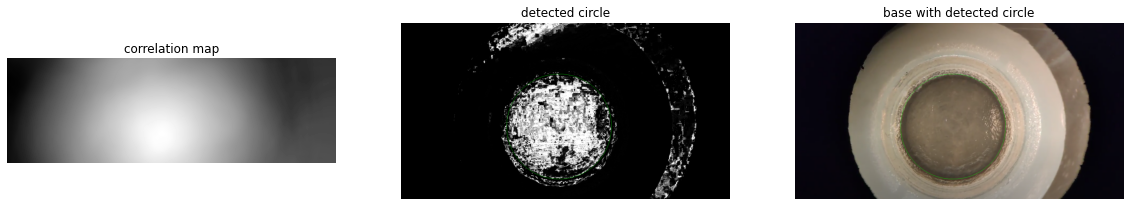

In [25]:
start = time.time()
result = cv2.matchTemplate(back_project, circle_kernel, cv2.TM_CCORR_NORMED)
end = time.time()

min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

max_loc_adj = (max_loc[0] + circle_kernel.shape[0]//2,
               max_loc[1] + circle_kernel.shape[1]//2)
back_project_copy = cv2.cvtColor(back_project, cv2.COLOR_GRAY2RGB)
cv2.circle(back_project_copy, max_loc_adj, CORRECT_CIRCLE_RADIUS, (0, 255, 0))

base_rgb_copy = base_rgb.copy()
cv2.circle(base_rgb_copy, max_loc_adj, CORRECT_CIRCLE_RADIUS, (0, 255, 0))

# visualization
print('matchTemplate total time: %f s, %f fps' %
      ((end - start), 1/(end - start)))
print('max_val: %s, max_loc: %s' % (str(max_val), str(max_loc)))

fig, plots = plt.subplots(1, 3, figsize=(20, 8))
plots[0].set_title('correlation map')
plots[0].imshow(cv2.normalize(result, None, 255, 0,
                cv2.NORM_MINMAX, cv2.CV_8UC1), cmap='gray')
plots[0].axis('off')

plots[1].set_title('detected circle')
plots[1].imshow(back_project_copy)
plots[1].axis('off')

plots[2].set_title('base with detected circle')
plots[2].imshow(base_rgb_copy)
plots[2].axis('off')

plt.show()

Video demo

In [26]:
cap = cv2.VideoCapture('data/artificial/rhexis_input_long2.mp4')
_, frame = cap.read()
view_mask, view_circle = get_view_mask(cv2.cvtColor(
    frame, cv2.COLOR_BGR2GRAY), return_circle=True)

while cap.isOpened():
    ret, frame = cap.read()

    # performance measurement
    timer = cv2.getTickCount()

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    back_project = cv2.calcBackProject(
        [hsv], [0, 1], hist_hs, [0, 180, 0, 256], 1)
    _, pupil_thres = cv2.threshold(back_project, 0, 255, cv2.THRESH_BINARY)

    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(
        pupil_thres)
    biggest_area_labels = np.flip(np.argsort(stats[:, 4]))
    pupil_thres[labels != biggest_area_labels[1]] = 0
    pupil_thres[labels == biggest_area_labels[1]] = 255

    blended = cv2.addWeighted(
        frame,
        0.8,
        cv2.cvtColor(pupil_thres, cv2.COLOR_GRAY2BGR),
        0.5,
        0.0
    )

    circle_corrected = detect_pupil_thresh(
        pupil_thres, pca_correction=True, pca_correction_ratio=0.0, morphology=False)

    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    if circle_corrected is not None:
        cv2.circle(frame, tuple(circle_corrected[:2].round().astype(np.int64)),
                   round(circle_corrected[2]), (0, 255, 0))
        cv2.putText(frame, 'fps %d' % round(fps),
                    (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                    (0, 255, 0), 1)
    else:
        cv2.putText(frame, 'detection failed',
                    (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                    (0, 0, 255), 1)

    cv2.imshow('blend', blended)
    cv2.imshow('thresholded', pupil_thres)
    cv2.imshow('original', frame)

    if cv2.waitKey(25) == ord('q'):
        break

cap.release()
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)

Not so stable and perfomant as well.